In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electionfinance/CandidateSummaryAction1.csv


# **What is the data**

In [2]:
data = pd.read_csv("../input/electionfinance/CandidateSummaryAction1.csv")

In [3]:
data.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,NaN,AUGUSTA,...,"$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,NaN,PHILADELPHIA,...,NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,NaN,JACKSONVILLE,...,NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,NaN,WHITEFISH,...,"$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",NaN,OAKLAND,...,"$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,1/1/2015,10/19/2016,Y,277390.0


In [4]:
data.shape


(1814, 51)

# Prepare data for analysis
1. drop all columns with above 90% missing value

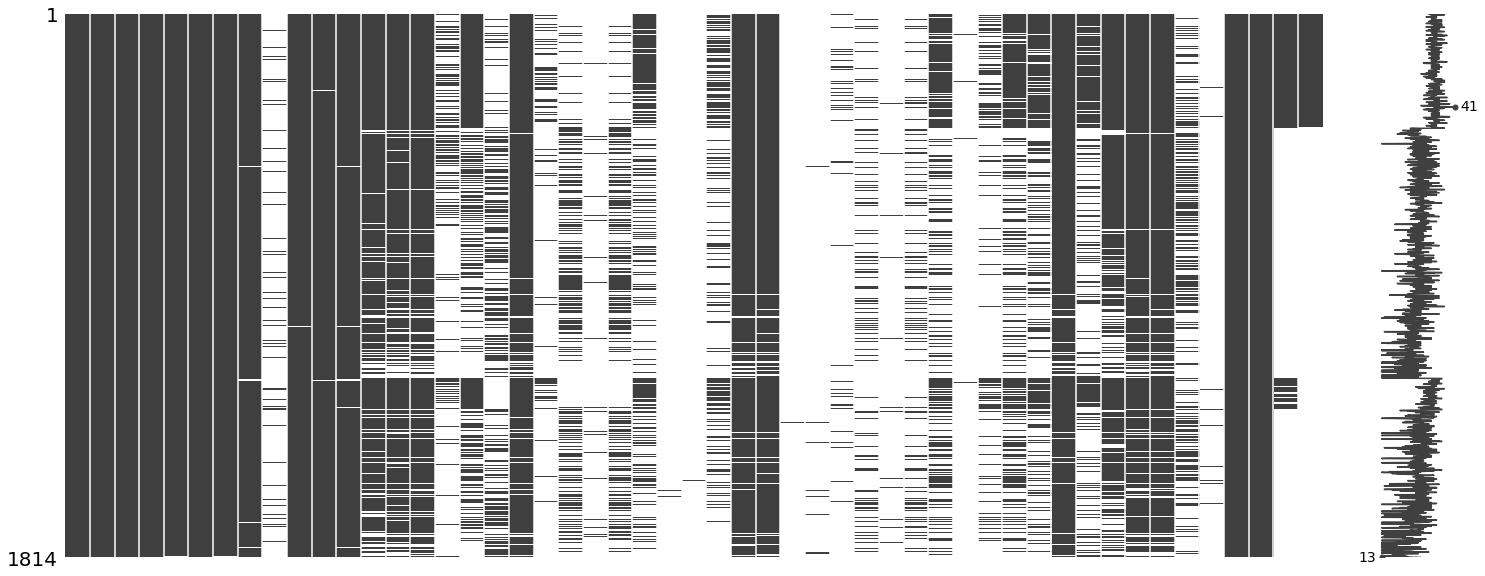

In [5]:
#first, visualize missing values
import missingno as msn
msn.matrix(data)

In [6]:
#process data values

data['cov_sta_dat'] = pd.to_datetime(data['cov_sta_dat'])
data['cov_end_dat'] = pd.to_datetime(data['cov_end_dat'])

data['campaign_duration'] = (data['cov_end_dat'] - data['cov_sta_dat']).dt.days

**Observation** 
1. data contains messy features 
2. create a function to deal with features with high percentage of missing data

In [7]:
#create a function to check all columns with missing data greater than 90% and drop them

def process_missing_data(data, threshold, inplace_value):
    #create a list to hold columns with missing value above threshold
    drop_cols = []
    
    #create a variable to store all columns in the dataframe
    all_cols = data.columns
    
    #calculate all columns with missing values percentage greater than the threshold
    missing_percentage = (data[all_cols].isna().sum()/len(data))*100
    
    #create a dataframe to store all candidate columns and their percentage
    missing_df = pd.DataFrame({"cols":all_cols, "percentage":missing_percentage})
    
    #check for threshold condition
    missing_filtered = missing_df[missing_df['percentage'] >= threshold] 
    drop_cols.append(missing_filtered["cols"].tolist())
    
    #drop candidate columns
    drop_cols = drop_cols[0]
    data.drop(columns=drop_cols, inplace= inplace_value)
    
    return data.shape


In [8]:
#call function on data
process_missing_data(data=data, threshold=90, inplace_value=True)

(1814, 42)

# **Explore the data**

**First, we see what offices the candidates are campaigning for**


In [9]:
data['can_off'].value_counts(normalize=True, sort=True) * 100

H    78.776185
S    12.513782
P     8.710033
Name: can_off, dtype: float64

**Basically, there are three offices namely**
* H : house of represenatative
* S : senator
* P : presidency

**create three dataframes based on the candidate office**

In [57]:
#first, convert the net_con column to a float data type and modify data inplace
def converter(data, data_col):
    value = data[data_col].str.replace('$','').str.replace(',','').str.replace('(','-').str.replace(')','').astype('float32')
    data[data_col] = value
    return data.head()

#call the function on the net_con feature
converter(data=data, data_col="net_ope_exp")

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,AUGUSTA,GA,...,"$60,109.57","$175,613.35",1074949.500,9.071562e+05,"$1,125,000.00",2015-01-01,2016-10-19,Y,158708.0,657
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,PHILADELPHIA,PA,...,NaN,"$105,687.23",1406719.000,1.298832e+06,NaN,2015-11-02,2016-10-19,Y,310770.0,352
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,JACKSONVILLE,FL,...,NaN,"$35,645.09",650855.375,6.562103e+05,"$60,000.00",2016-04-01,2016-10-19,Y,286018.0,201
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$83,815.78","$399,122.61",4938943.500,5.055942e+06,NaN,2015-01-01,2016-10-19,Y,280476.0,657
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",OAKLAND,CA,...,"$83,690.60","$181,338.23",1197676.625,9.494890e+05,"$4,401.75",2015-01-01,2016-10-19,Y,277390.0,657


**replace all the nan columns in the winner with N as they represent the losers**

In [11]:
data['winner'] = data['winner'].fillna('N')

**inference**
1. we are making use of the net_con feature as this is the feature that represents the total expenses of each candidate leading up to the election period

In [59]:
H_df = data.loc[data['can_off'] == "H"] 
S_df = data.loc[data['can_off'] == "S"]
P_df = data.loc[data['can_off'] == "P"]

In [60]:
#check the shape of the data

print(f'The shape of the House of assembly data is {H_df.shape}')
print(f'The shape of the senate data is {S_df.shape}')
print(f'The shape of the presidential data is {P_df.shape}')

The shape of the House of assembly data is (1429, 42)
The shape of the senate data is (227, 42)
The shape of the presidential data is (158, 42)


# let's start by analyzing the house of representative data

**Since we are interested in the finances of the campaign, lets see how much is spent on campaign in each district in a state**


In [61]:
Amt_per_sta_ds = H_df.groupby(['can_off_sta', 'can_off_dis'])['net_ope_exp'].sum().to_frame(name = "total_dis_sum").reset_index()

In [62]:
Amt_per_sta_ds.head()

,can_off_sta,can_off_dis,total_dis_sum
0,AK,0.0,1145563.625
1,AL,1.0,941648.875
2,AL,2.0,1557982.250
3,AL,3.0,880649.750
4,AL,4.0,1319197.125


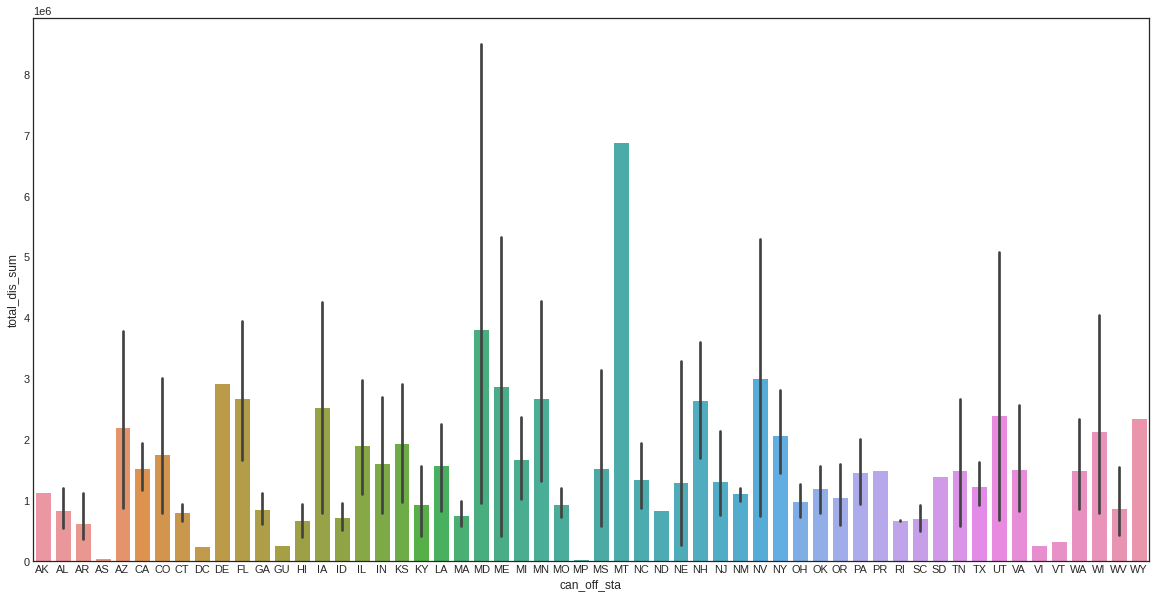

In [63]:
#visualize the state with high spending

plt.figure(figsize=(20,10))

ax = sns.barplot(x="can_off_sta", y="total_dis_sum", data=Amt_per_sta_ds)

We can clearly see that the highest spending state in terms of house of reps election is the MT, let's now go further to analyze the state with the highest net_contribution

In [69]:
mt_comp = H_df.loc[H_df['can_off_sta'] == 'MT']
mt_comp

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$83,815.78","$399,122.61",4938943.5,5055942.00,NaN,2015-01-01,2016-10-19,Y,280476.0,657
535,H6MT01095,"JUNEAU, DENISE",H,MT,0.0,DEM,CHALLENGER,PO BOX 563,HELENA,MT,...,NaN,"$491,337.79",2317465.0,1831515.25,NaN,2015-11-04,2016-10-19,N,NaN,350


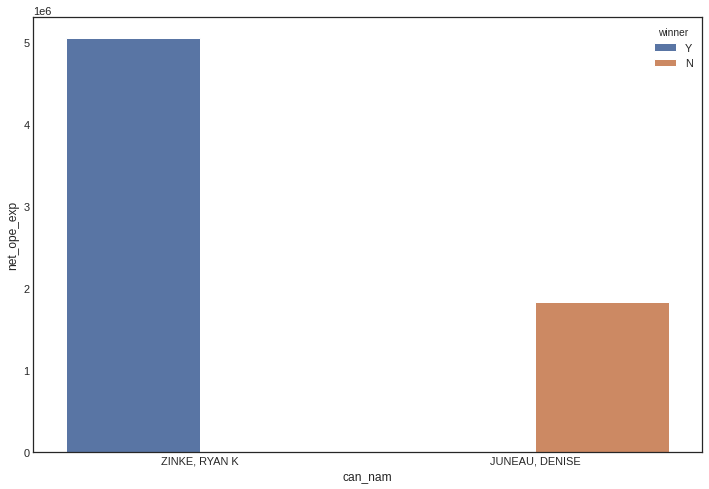

In [66]:
ax = sns.barplot(x='can_nam', y='net_ope_exp', hue = 'winner',data=mt_comp)

**Observation**
1. **we can see the state has just one district with only two competitors, yet they have the higest rate of spending this can be due to a various reasons that are sadly not contained in the data. suggestions include:**
    * The cost of getting things done in that state is relatively high in comparison to other states
    * Being in direct competition creates just one collision point for the candidates 
2. **we can also see that the candidate with the highest spending won the election**


    

we can clearly see that for state MT with just one district, the higest spender won the vote, however, before we conclude, let's check how long each candidate campaigned for.
* reason behind this is the fact that time plays a role in the maturity of an investment. so assuming the campaign is the investemnt, net_con is the invested capital, how long will it take for the said investement to mature. 
* naturally, the longer you keep your investment, the higher your profit gets, therefore, it should hold that the longer you campaign, the more likely it is for you to win, we check if this assumption holds

In [70]:
mt_comp

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$83,815.78","$399,122.61",4938943.5,5055942.00,NaN,2015-01-01,2016-10-19,Y,280476.0,657
535,H6MT01095,"JUNEAU, DENISE",H,MT,0.0,DEM,CHALLENGER,PO BOX 563,HELENA,MT,...,NaN,"$491,337.79",2317465.0,1831515.25,NaN,2015-11-04,2016-10-19,N,NaN,350


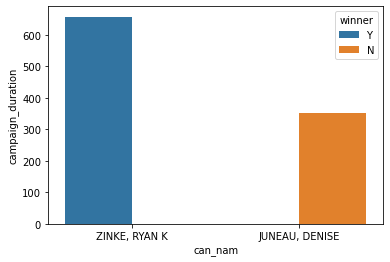

In [20]:
ax = sns.barplot(x='can_nam', y='campaign_duration',hue='winner', data=mt_comp)

**Observation**
* The investment assumption holds

**Next, we seek to find out the number of candidates vying for a sit in a district(competitors) generally **

In [21]:
competitors = H_df.groupby(['can_off_sta', 'can_off_dis'])['can_id'].count().to_frame(name = "num_of_comp").reset_index()
#eliminate data points where num_of_comp <= 1
#this means that these positions are unopposed
competitors = competitors[competitors['num_of_comp'] > 1]

In [71]:
competitors.head()

,can_off_sta,can_off_dis,num_of_comp
1,AL,1.0,2
2,AL,2.0,3
3,AL,3.0,3
4,AL,4.0,2
5,AL,5.0,2


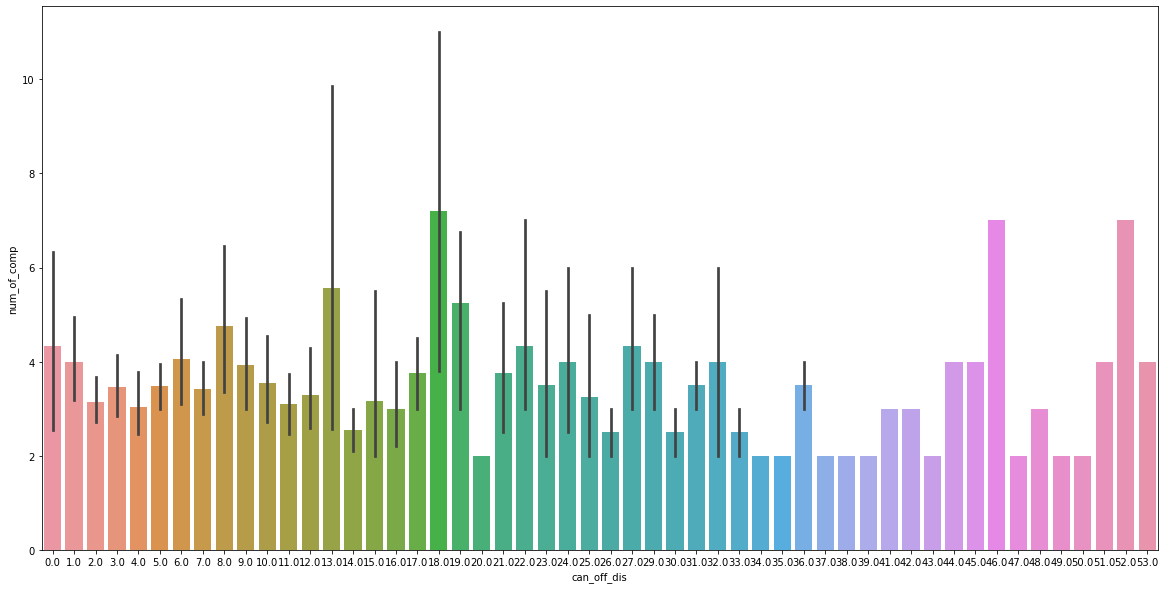

In [23]:
plt.figure(figsize=(20,10))

ax = sns.barplot(x="can_off_dis", y="num_of_comp", data=competitors)

**Observation**
* here we can see every district represented in our dataset clearly

### Before generalizing, let's pick a state at random and test the result of our early analysis

In [72]:
al_comp = H_df.loc[H_df['can_off_sta'] == 'AL']
al_comp.shape

(15, 42)

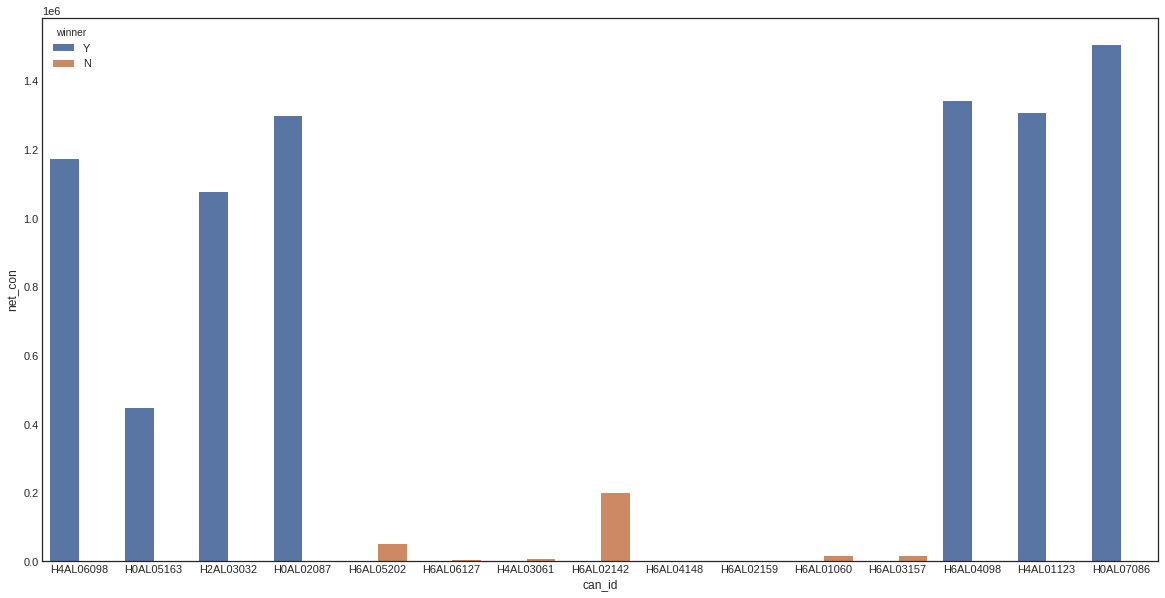

In [73]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x='can_id', y='net_con', hue = 'winner',data=al_comp)

**Inference**
* assumption on the relationship between how much a candidate spends on election and winning holds
* visualize to see what the range of highest amount spent is

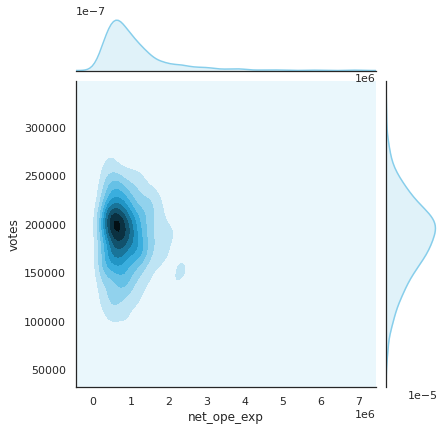

In [74]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style="white", color_codes=True)
sns.jointplot(x=H_df["net_ope_exp"], y=H_df["votes"], kind='kde', color="skyblue")

**by this inspection, we can see the concentration of where the most money is spent and the expected voters**

# Haven explored the house of rep dataset, we move to explore senetorial campaigns

In [75]:
S_df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
379,S6IL00292,"DUCKWORTH, L TAMMY",S,IL,0.0,DEM,CHALLENGER,PO BOX 10793,CHICAGO,IL,...,NaN,"$2,520,008.00",13059804.0,12412571.0,NaN,2015-03-30,2016-10-19,Y,NaN,569
380,S6NH00091,"HASSAN, MARGARET WOOD",S,NH,0.0,DEM,CHALLENGER,PO BOX 298,CONCORD,NH,...,NaN,"$1,805,530.00",14006424.0,13622825.0,NaN,2015-10-05,2016-10-19,Y,NaN,380
383,S6CO00309,"GRAHAM, JOHN COLLINS",S,CO,0.0,REP,CHALLENGER,PO BOX 101177,DENVER,CO,...,NaN,NaN,483847.0,2358939.0,NaN,2016-01-01,2016-12-31,N,NaN,365
399,S0KS00166,"WIESNER, PATRICK",S,KS,0.0,DEM,CHALLENGER,2717 ANN COURT,LAWRENCE,KS,...,"$2,653.00","$8,070.00",15026.0,29603.0,"$20,000.00",2015-01-01,2016-10-28,N,NaN,666
402,S6OR05085,"STINE, KEVIN",S,OR,0.0,DEM,CHALLENGER,PO BOX 1209,MEDFORD,OR,...,NaN,NaN,5735.0,6436.0,$702.00,2015-09-01,2016-10-25,N,NaN,420


**Insights**
* **Article I, section 3 of the USA Constitution states that** 
* The Senate of the United States shall be composed of two Senators from each State, chosen by the Legislature thereof, for six Years; and each Senator shall have one Vote. Immediately after they shall be assembled in Consequence of the first Election, they shall be divided as equally as may be into three Classes.

**Focus**
* our aim is to check for a relationship in the finance and voting tournout so we proceed in line
* by research the voters column of the dataframe should be empty as the election is not open to public voting

**inference**
* check to ascertain second focus

In [76]:
prf1 = S_df['votes'].isna().count()
prf2 =  len(S_df['votes'])

print(prf1)
print(prf2)

227
227


**Observation**
* research holds so we proceed to drop the votes feature in our dataframe


In [77]:
S_df.drop(columns='votes', inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [78]:
S_df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,campaign_duration
379,S6IL00292,"DUCKWORTH, L TAMMY",S,IL,0.0,DEM,CHALLENGER,PO BOX 10793,CHICAGO,IL,...,"$12,991,223.00",NaN,"$2,520,008.00",13059804.0,12412571.0,NaN,2015-03-30,2016-10-19,Y,569
380,S6NH00091,"HASSAN, MARGARET WOOD",S,NH,0.0,DEM,CHALLENGER,PO BOX 298,CONCORD,NH,...,"$13,720,969.00",NaN,"$1,805,530.00",14006424.0,13622825.0,NaN,2015-10-05,2016-10-19,Y,380
383,S6CO00309,"GRAHAM, JOHN COLLINS",S,CO,0.0,REP,CHALLENGER,PO BOX 101177,DENVER,CO,...,"$2,365,130.00",NaN,NaN,483847.0,2358939.0,NaN,2016-01-01,2016-12-31,N,365
399,S0KS00166,"WIESNER, PATRICK",S,KS,0.0,DEM,CHALLENGER,2717 ANN COURT,LAWRENCE,KS,...,"$29,603.00","$2,653.00","$8,070.00",15026.0,29603.0,"$20,000.00",2015-01-01,2016-10-28,N,666
402,S6OR05085,"STINE, KEVIN",S,OR,0.0,DEM,CHALLENGER,PO BOX 1209,MEDFORD,OR,...,"$8,733.00",NaN,NaN,5735.0,6436.0,$702.00,2015-09-01,2016-10-25,N,420


In [79]:
#first, we check amount spent per state 
Amt_per_sta_ds = S_df.groupby(['can_off_sta', 'can_off_dis'])['net_ope_exp'].sum().to_frame(name = "total_dis_sum").reset_index()

In [80]:
Amt_per_sta_ds.head()

,can_off_sta,can_off_dis,total_dis_sum
0,AK,0.0,5250057.0
1,AL,0.0,12234151.0
2,AR,0.0,4802073.0
3,AZ,0.0,20388834.0
4,CA,0.0,16926962.0


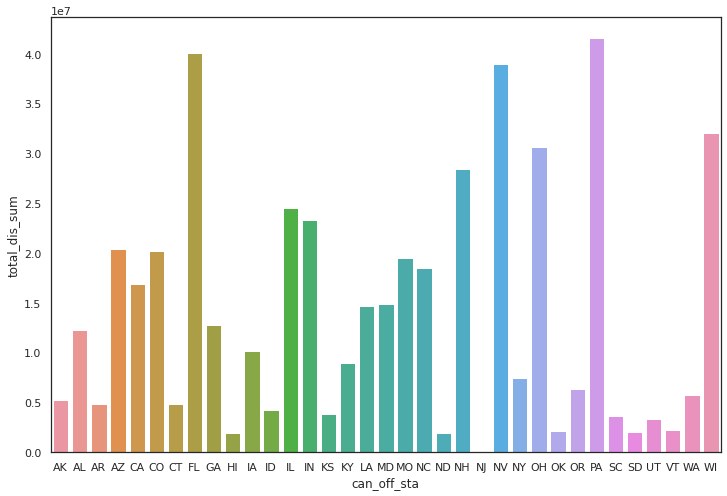

In [81]:
#visualize to see the highest spending state

plt.Figure(figsize=(20,10))
ax = sns.barplot(x='can_off_sta', y='total_dis_sum', data=Amt_per_sta_ds)

**Obeservation**
* three states show high total money spent which are **FL, PA and WI**
* analyze the winners of these three states to observe trends

In [83]:
#create the three dataframes
fl_comp = S_df.loc[S_df['can_off_sta'] == 'FL']
pa_comp = S_df.loc[S_df['can_off_sta'] == 'PA']
nv_comp = S_df.loc[S_df['can_off_sta'] == 'NV']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

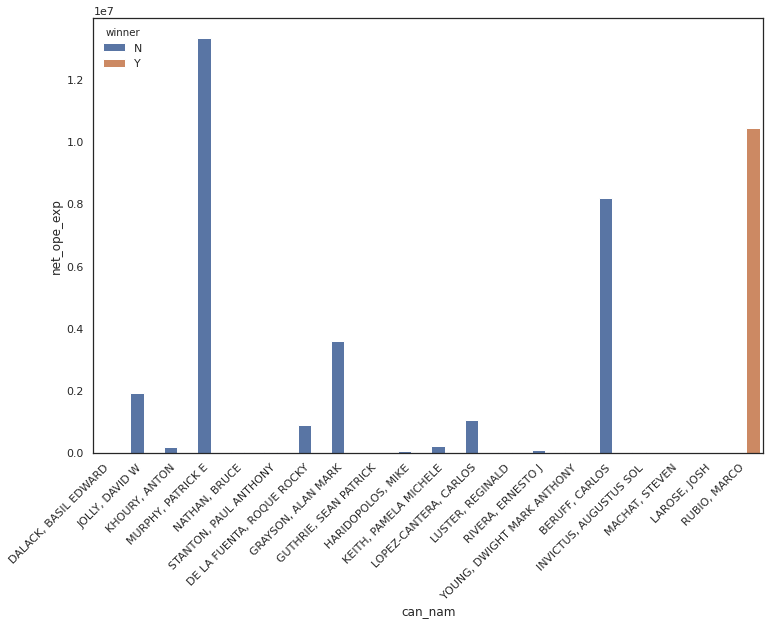

In [84]:
#check winners in FL

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='winner', data=fl_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

**Observation**
* the highest spender wasn't the winner, to check why this is happening, we inspect with our investment analogy and check how long they have been campaigning for


In [85]:
fl_comp.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,campaign_duration
470,S6FL00459,"DALACK, BASIL EDWARD",S,FL,0.0,REP,CHALLENGER,225 GOLFVIEW DRIVE,TEQUESTA,FL,...,"$7,318.00",NaN,$0.92,5220.0,10.0,NaN,2016-04-13,2016-10-19,N,189
532,S6FL00350,"JOLLY, DAVID W",S,FL,0.0,REP,CHALLENGER,PO BOX 1158,INDIAN ROCKS BEACH,FL,...,"$1,970,657.96","$246,339.09","$158,630.58",1826910.0,1915656.0,NaN,2015-01-01,2016-10-19,N,657
542,S6FL00434,"KHOURY, ANTON",S,FL,0.0,OTH,CHALLENGER,PO BOX 565087,MIAMI,FL,...,"$171,969.00",NaN,"$42,098.00",73821.0,171719.0,"$140,000.00",2016-01-01,2016-10-19,N,292
597,S6FL00319,"MURPHY, PATRICK E",S,FL,0.0,DEM,CHALLENGER,4521 PGA BLVD #412,PALM BEACH GARDENS,FL,...,"$13,438,036.00","$536,659.00","$1,642,826.00",13682705.0,13324181.0,NaN,2015-01-01,2016-10-19,N,657
599,S6FL00327,"NATHAN, BRUCE",S,FL,0.0,IND,CHALLENGER,3230 SW ISLAND WAY,PALM CITY,FL,...,"$17,710.00",NaN,$4.00,3116.0,17150.0,"$14,041.00",2015-06-20,2016-10-19,N,487


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

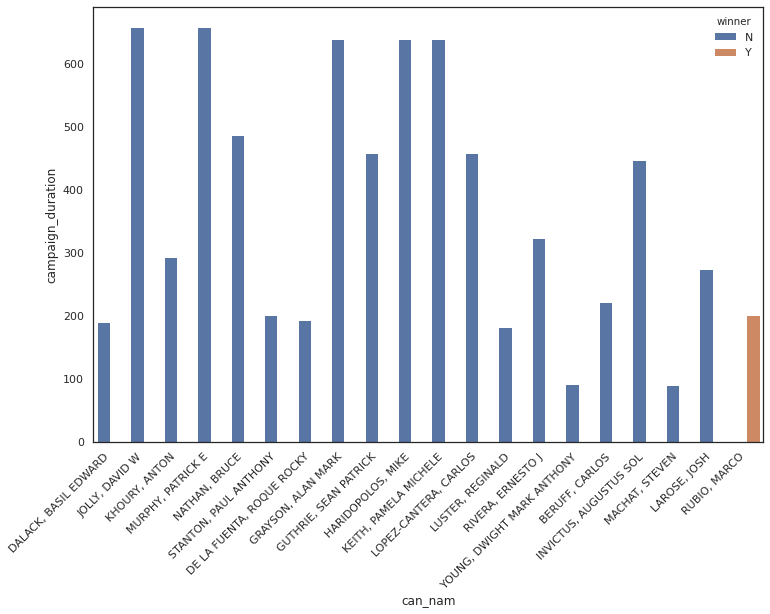

In [86]:
ax = sns.barplot(x='can_nam', y='campaign_duration', hue='winner', data=fl_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

**Observation**
* we still come short in our investment idealogy, next we check for the number of party affiliation in the respective district

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

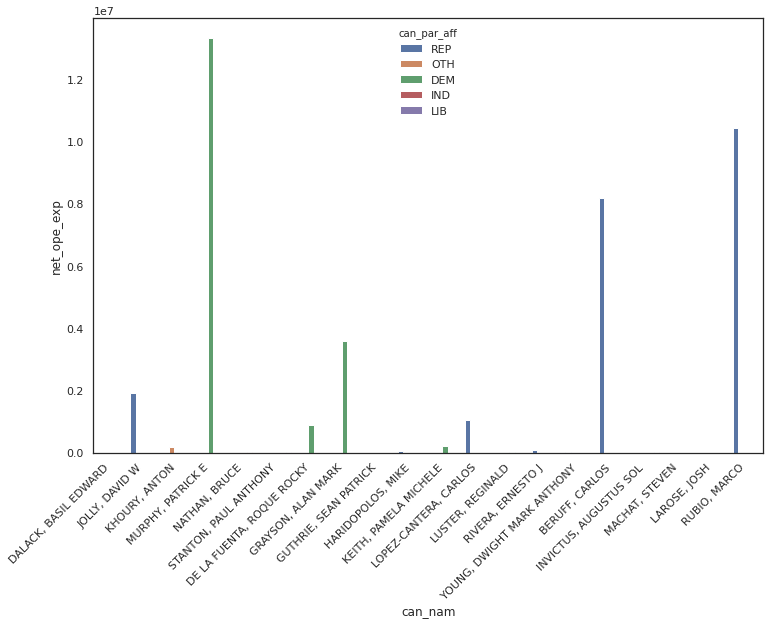

In [87]:
ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='can_par_aff', data=fl_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

**observation**
* we can see a variation in their party affiliations , lets check if they are from the majority or minority party for that state


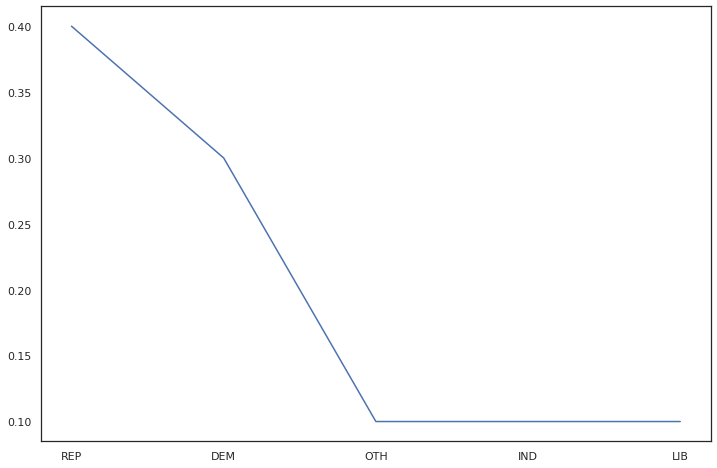

In [88]:
fl_comp['can_par_aff'].value_counts(normalize=True, sort=True).plot()

**Observation**
* we have our inlier insight as we can see, the party affiliation plays a big role in the voting outcome

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

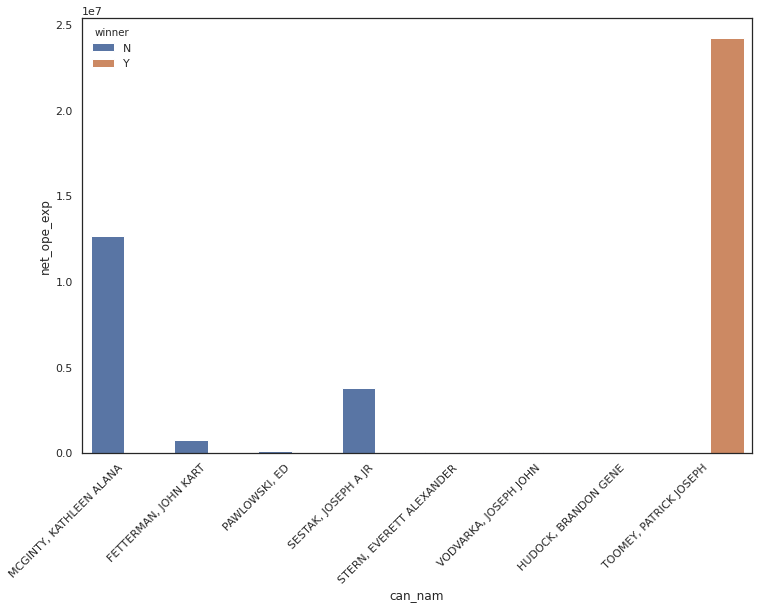

In [89]:
#check winners in PA

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='winner', data=pa_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

* here we can see that right off the box, the candidate with the highest contribution won the election, we will test the other assumption of investment time and party affiliation next


Text(0.5, 1.0, 'dominant party')

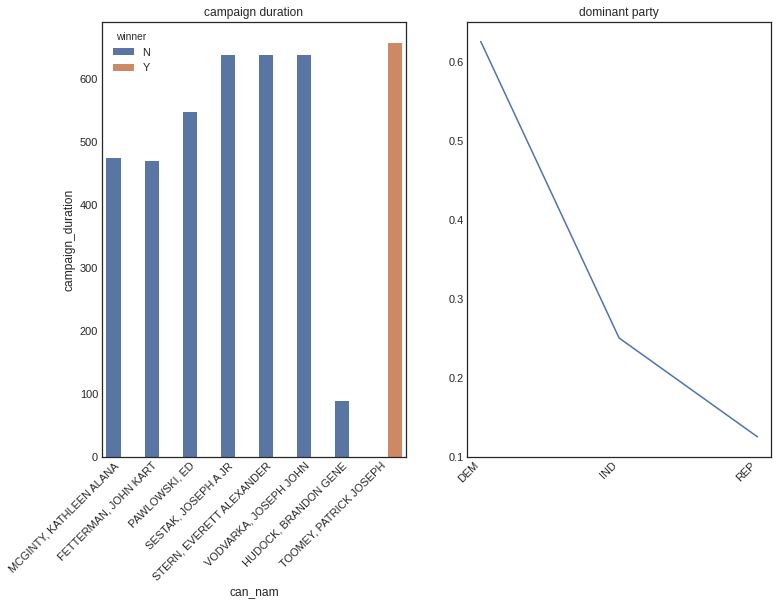

In [90]:

plt.style.use('seaborn-white')
plt.subplot(121)
ax = sns.barplot(x='can_nam', y='campaign_duration', hue='winner', data=pa_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")


plt.subplot(122)
pa_comp['can_par_aff'].value_counts(normalize=True, sort=True).plot()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("dominant party")




Text(0.5, 1.0, 'campaign duration')

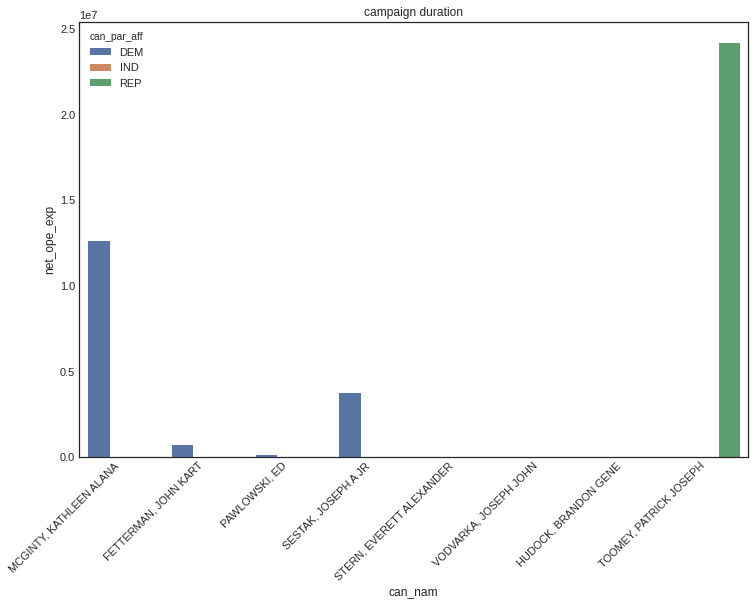

In [91]:

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='can_par_aff', data=pa_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")


**Inference**
* assumption fails. this can be a function of the coefficient of that variable 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

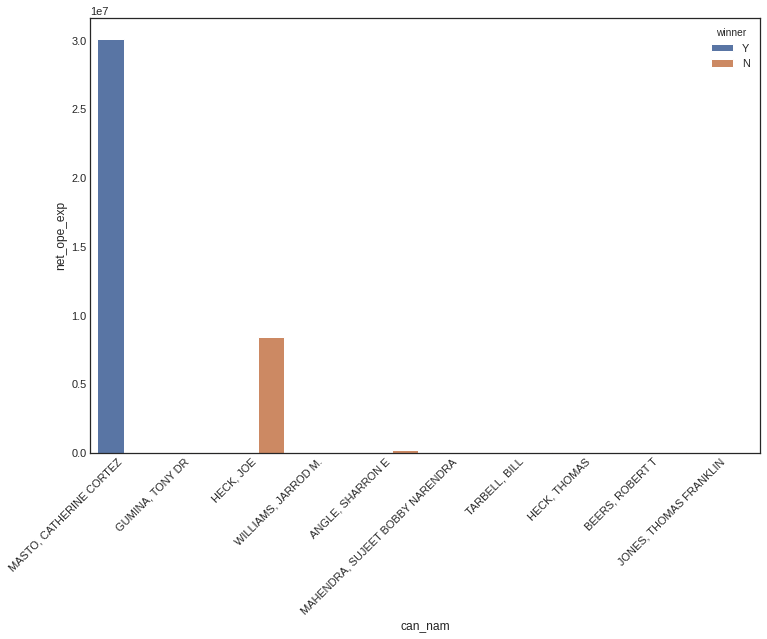

In [92]:
#check winners in PA

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='winner', data=nv_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

**Observation**
* holds to our first assumption, as we can see
* test investment and party assumption

Text(0.5, 1.0, 'dominant party')

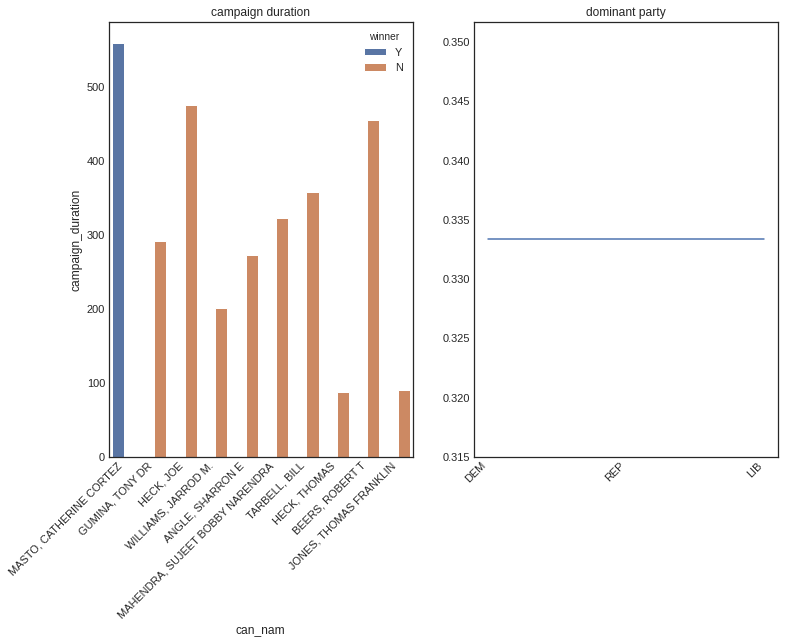

In [94]:
plt.style.use('seaborn-white')
plt.subplot(121)
ax = sns.barplot(x='can_nam', y='campaign_duration', hue='winner', data=nv_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")


plt.subplot(122)
wi_comp['can_par_aff'].value_counts(normalize=True, sort=True).plot()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("dominant party")


Text(0.5, 1.0, 'campaign duration')

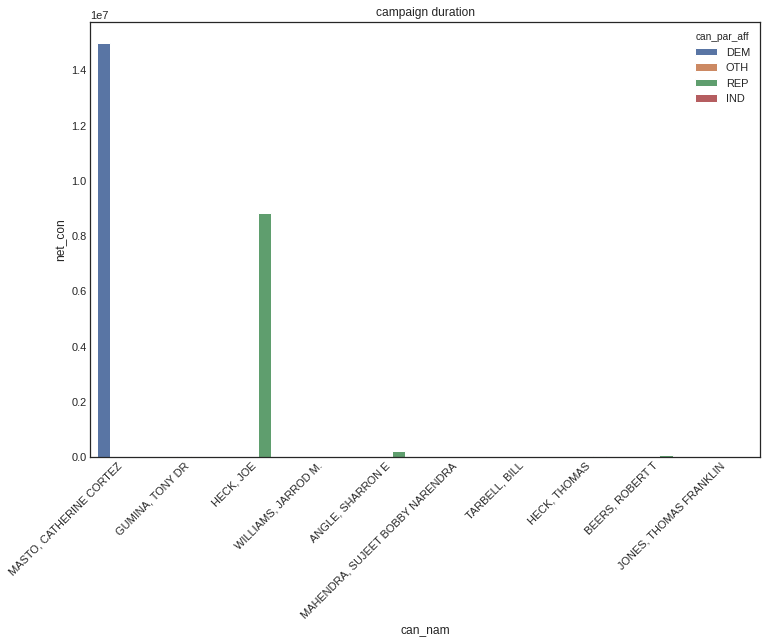

In [96]:
ax = sns.barplot(x='can_nam', y='net_con', hue='can_par_aff', data=nv_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")

# Presidential Data Analysis

In [97]:
P_df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
1199,P20000089,"FELLURE, LOWELL JACKSON",P,US,0.0,REP,CHALLENGER,682 ORCHARD PARK ROAD,HURRICANE,WV,...,$590.00,$590.00,NaN,NaN,"$3,762.00",2015-01-01,2015-09-30,N,NaN,272
1208,P60006202,"JONES, DANNY ROYCE MR. SR.",P,US,0.0,REP,CHALLENGER,609 SW 1ST STREET,KERENS,TX,...,NaN,NaN,NaN,NaN,NaN,2015-01-01,2015-06-30,N,NaN,180
1319,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",P,US,0.0,REP,OPEN,725 FIFTH AVENUE,NEW YORK,NY,...,NaN,"$15,994,453.57",468441888.0,923651008.0,"$2,086,572.41",2015-04-02,2016-10-19,Y,NaN,566
1322,P60005154,"CLARK, BRITTANY",P,US,0.0,PPY,OPEN,"28200 HIGHWAY 189, SUITE F-240-20",LAKE ARROWHEAD,CA,...,NaN,"$6,453.00",NaN,NaN,"$19,586.00",2016-01-31,2017-01-31,N,NaN,366
1323,P60016383,"KITTINGTON, VALMA",P,US,0.0,REP,OPEN,79 RANDOLPH STREET,MIDLAND CITY,AL,...,NaN,NaN,NaN,NaN,NaN,2015-07-15,2016-12-31,N,NaN,535


In [98]:
P_df.shape

(158, 42)

In [48]:
#create dataframe grouped by total amount spent
Amt_per_sta_ds = P_df.groupby(['can_nam', 'winner', 'can_par_aff', 'campaign_duration'])['net_ope_exp'].sum().to_frame(name = "total_dis_sum")

In [49]:
#sort result
Amt_per_sta_ds = Amt_per_sta_ds.sort_values(by = ['total_dis_sum'], ascending=False).reset_index()

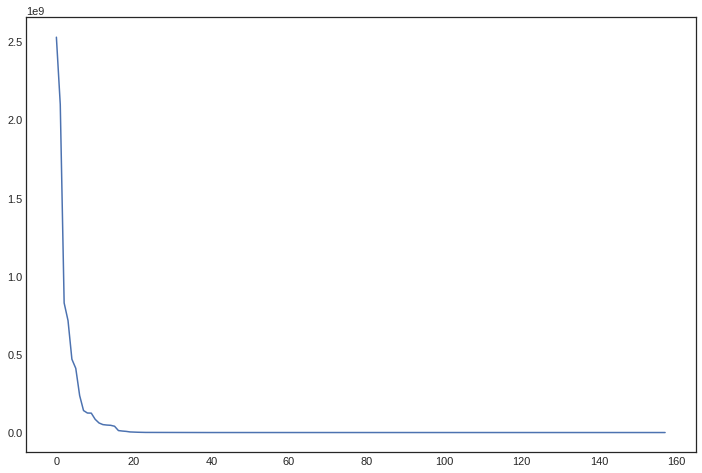

In [50]:
#create visualization to reach an assumption on which section of the data points could be candidates to win the election
Amt_per_sta_ds['total_dis_sum'].plot()


In [51]:
# select first 20 data points as candidates
Amt_per_sta_ds = Amt_per_sta_ds.iloc[:20, :]

In [52]:
Amt_per_sta_ds

,can_nam,winner,can_par_aff,campaign_duration,total_dis_sum
0,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",N,DEM,567,2.526103e+09
1,"SANDERS, BERNARD",N,DEM,567,2.096280e+09
2,"CRUZ, RAFAEL EDWARD TED""""",N,REP,638,8.279308e+08
3,"CARSON, BENJAMIN S SR MD",N,REP,669,7.155557e+08
4,"TRUMP, DONALD J. / MICHAEL R. PENCE",Y,REP,566,4.684419e+08
5,"RUBIO, MARCO",N,REP,638,4.100464e+08
6,"BUSH, JEB",N,REP,548,2.363354e+08
7,"FIORINA, CARLY",N,REP,579,1.404609e+08
8,"KASICH, JOHN R",N,REP,457,1.246618e+08
9,"PAUL, RAND",N,REP,579,1.239502e+08


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

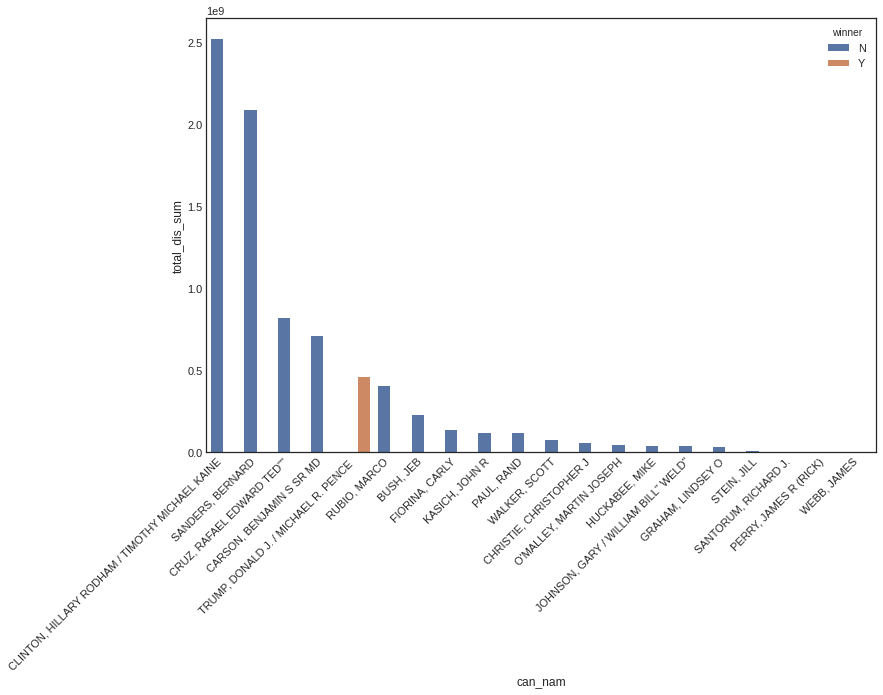

In [53]:
#check winner
ax = sns.barplot(x='can_nam', y = 'total_dis_sum', hue='winner', data=Amt_per_sta_ds)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)


**observation**
* first assumption did not hold, lets find if our data has the ability to give insight to why this is by analyzing the campaign duration and party affiliation

Text(0.5, 1.0, 'dominant party')

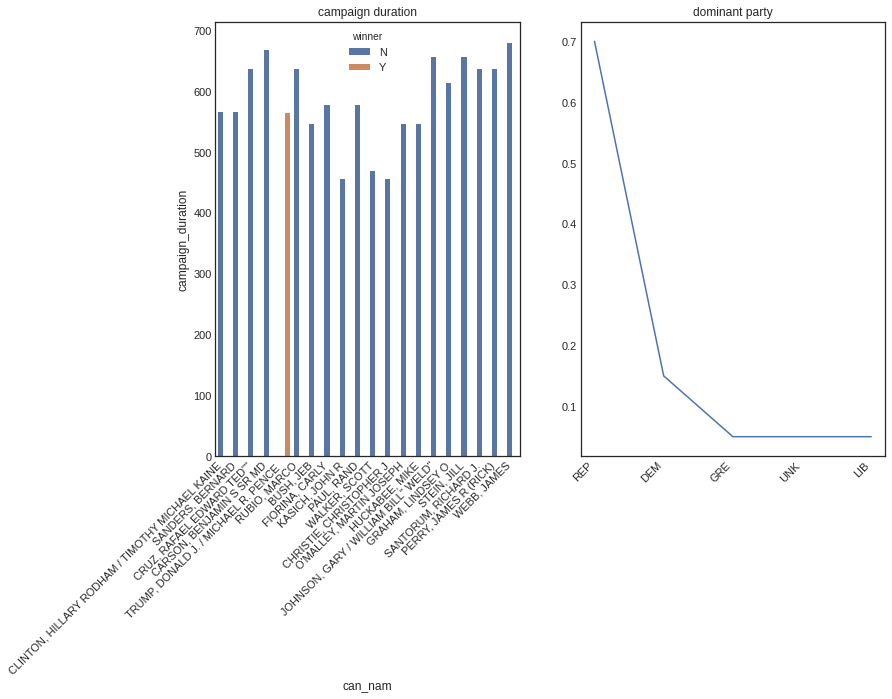

In [54]:
plt.style.use('seaborn-white')
plt.subplot(121)
ax = sns.barplot(x='can_nam', y='campaign_duration', hue='winner', data=Amt_per_sta_ds)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")


plt.subplot(122)
Amt_per_sta_ds['can_par_aff'].value_counts(normalize=True, sort=True).plot()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("dominant party")

Text(0.5, 1.0, 'campaign duration')

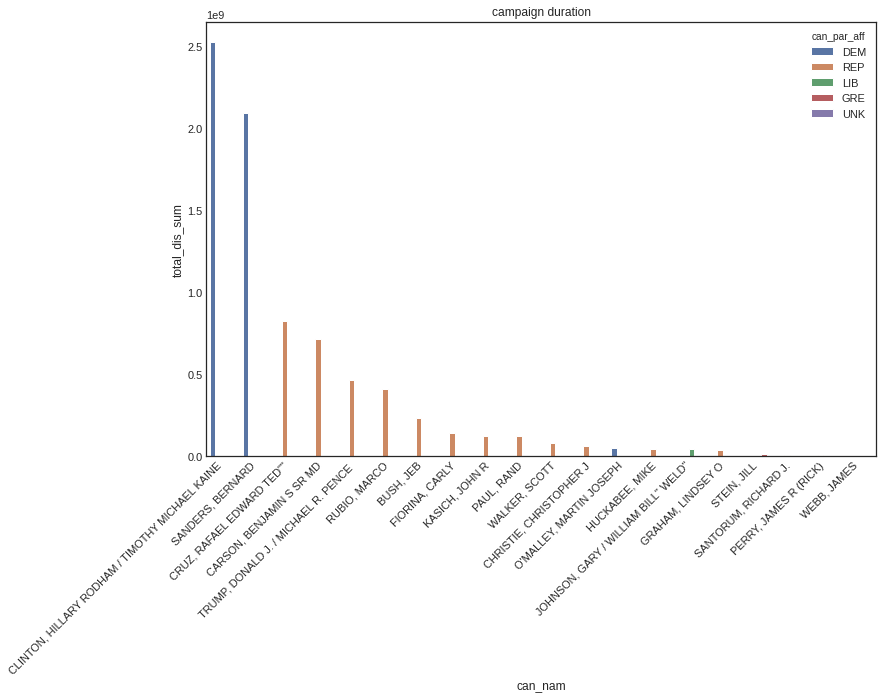

In [55]:
ax = sns.barplot(x='can_nam', y='total_dis_sum', hue='can_par_aff', data=Amt_per_sta_ds)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")

**Observation**
* MYSTERY SOLVED!!! Party affiliations solved the problem

# MODEL BUILDING
* The features that we've analyzed to matter